In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

from src import data

from netneurotools import metrics
    # https://netneurotools.readthedocs.io/en/latest/, pip install netneurotools does not work for me
    # I downloaded the repository and I am using the local copy

%matplotlib inline

!date -I

2024-04-10


## Settings

In [3]:
parcellations = {"DKT","MNI-HCP-MMP1"} # MNI-HCP-MMP1 is another name for Glasser parcellation

# following ROIs are not present in enigma with DKT parcellation,
# so it should be deleted from responses to have matching dimensions
ids_to_delete_in_dkt = [37,3] 

# set parecallation to use for structural connectivity
# availible parcellations listed above
PARCELLATION =  "MNI-HCP-MMP1"
AMPLITUDE_MASK_SAME_AS_PROBABILITY_MASK = False


if PARCELLATION not in parcellations:
    print(f"Selected parcellation {PARCELLATION} not in availible parcellations!")

## Load data

### Load F-TRACT data

In [4]:
# F-TRACT dataset is availible in several parcellations, select and load the one defined above
ftract_labels = data.load_ftract_labels(PARCELLATION)

### Load structural (and functional) connectivity data

In [5]:
SC_matrices = []

if PARCELLATION == "DKT":
    SC_matrices = data.load_set_of_DKT_matrices_for_ftract(ftract_labels,ids_to_delete_in_dkt)
    ED = None

elif PARCELLATION == "MNI-HCP-MMP1":
    labels = data.glasser_labels()
    ED = data.glasser_roi_distances()
    ED = data.roi_remappnig.reorder_matrix_based_on_reference(labels,ftract_labels,ED)

    SC_matrices = data.load_set_of_glasser_matrices_for_ftract(ftract_labels,ED)

number_of_SC = len(SC_matrices)

/home/katterrina/fi_muni/0_diplomka/src/data.py:318: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append(("Mica-Mics_rh",SC_W_M, SC_L_M,np.log(SC_W_M)))
/home/katterrina/fi_muni/0_diplomka/src/data.py:319: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append(("Mica-Mics_simple",SC_W_M_mean, SC_L_M_mean,np.log(SC_W_M_mean)))
/home/katterrina/fi_muni/0_diplomka/src/data.py:320: RuntimeWarning: divide by zero encountered in log
  SC_matrices.append(("Mica-Mics_dist",SC_W_M_dist, SC_L_M_dist,np.log(SC_W_M_dist)))


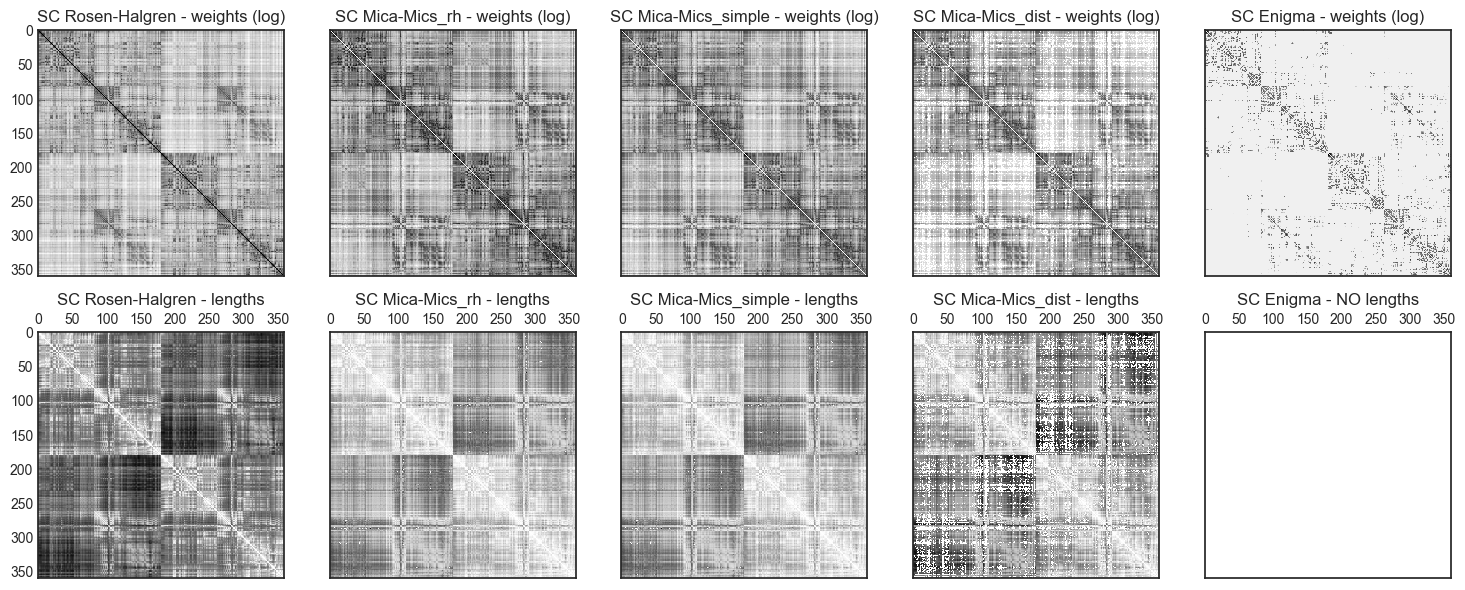

In [6]:
plt.rcParams['figure.figsize'] = [3*number_of_SC,6]
plt.style.use('seaborn-v0_8-white')

fig, axs = plt.subplots(2,number_of_SC, tight_layout=True,sharex=True,sharey=True)

for i in range(number_of_SC):
    name, SC_W, SC_L, SC_W_log = SC_matrices[i]

    axs[0,i].matshow(SC_W_log)
    axs[0,i].set_title(f"SC {name} - weights (log)")

    if SC_L is not None:
        axs[1,i].matshow(SC_L)
        axs[1,i].set_title(f"SC {name} - lengths")

    else:
        axs[1,i].matshow(np.zeros(SC_W.shape))
        axs[1,i].set_title(f"SC {name} - NO lengths")

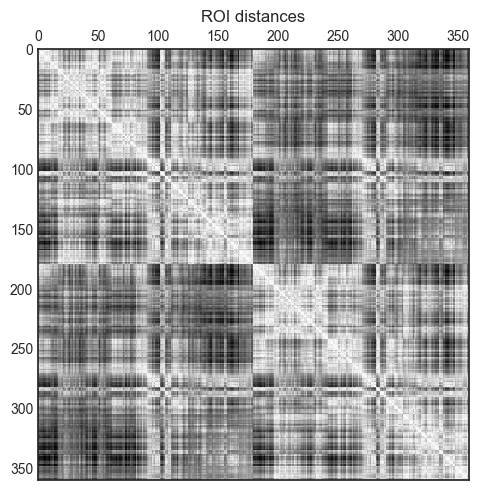

In [7]:
if ED is not None:
    plt.rcParams['figure.figsize'] = [5,5]
    fig, axs = plt.subplots(1, 1, tight_layout=True)
    axs.matshow(ED)
    axs.set_title("ROI distances")

In [8]:
plt.style.use('ggplot')

In [12]:
df_weights = pd.DataFrame()
df_lengths = pd.DataFrame()

for name, SC_W, SC_L, SC_W_log in SC_matrices:
    df_weights[name] = SC_W.flatten()
    if SC_L is not None:
        df_lengths[name] = SC_L.flatten()

In [14]:
pg.pairwise_corr(df_weights)

,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,Rosen-Halgren,Mica-Mics_rh,pearson,two-sided,129600,0.082660,"[0.08, 0.09]",3.032198e-195,3.054e+190,1.0
1,Rosen-Halgren,Mica-Mics_simple,pearson,two-sided,129600,0.058778,"[0.05, 0.06]",1.512843e-99,8.628e+94,1.0
2,Rosen-Halgren,Mica-Mics_dist,pearson,two-sided,129600,0.058775,"[0.05, 0.06]",1.557899e-99,8.379e+94,1.0
3,Rosen-Halgren,Enigma,pearson,two-sided,129600,0.063141,"[0.06, 0.07]",1.331909e-114,9.121e+109,1.0
4,Mica-Mics_rh,Mica-Mics_simple,pearson,two-sided,129600,0.784581,"[0.78, 0.79]",0.000000e+00,inf,1.0
5,Mica-Mics_rh,Mica-Mics_dist,pearson,two-sided,129600,0.784276,"[0.78, 0.79]",0.000000e+00,inf,1.0
6,Mica-Mics_rh,Enigma,pearson,two-sided,129600,0.636581,"[0.63, 0.64]",0.000000e+00,inf,1.0
7,Mica-Mics_simple,Mica-Mics_dist,pearson,two-sided,129600,0.999830,"[1.0, 1.0]",0.000000e+00,nan,1.0
8,Mica-Mics_simple,Enigma,pearson,two-sided,129600,0.892094,"[0.89, 0.89]",0.000000e+00,inf,1.0
9,Mica-Mics_dist,Enigma,pearson,two-sided,129600,0.892079,"[0.89, 0.89]",0.000000e+00,inf,1.0


In [27]:
sns.set_theme(rc={'figure.figsize':(15,7)})

<Axes: ylabel='Count'>

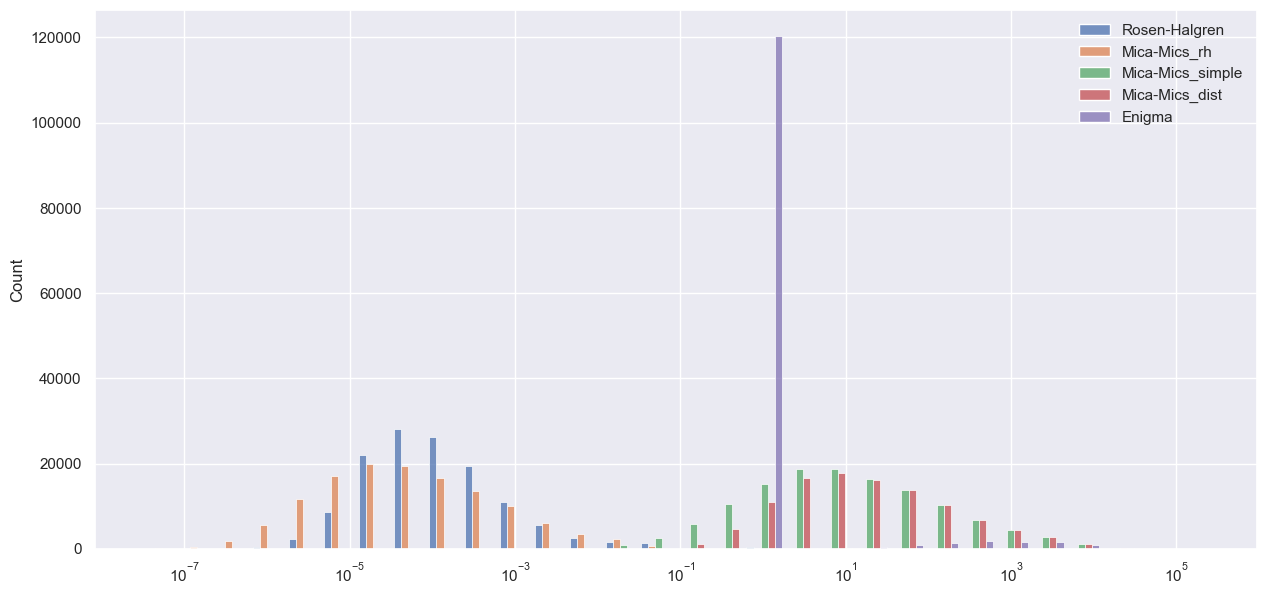

In [33]:
sns.histplot(df_weights,bins=30,log_scale=True,multiple="dodge", common_norm=False)

<Axes: ylabel='Count'>

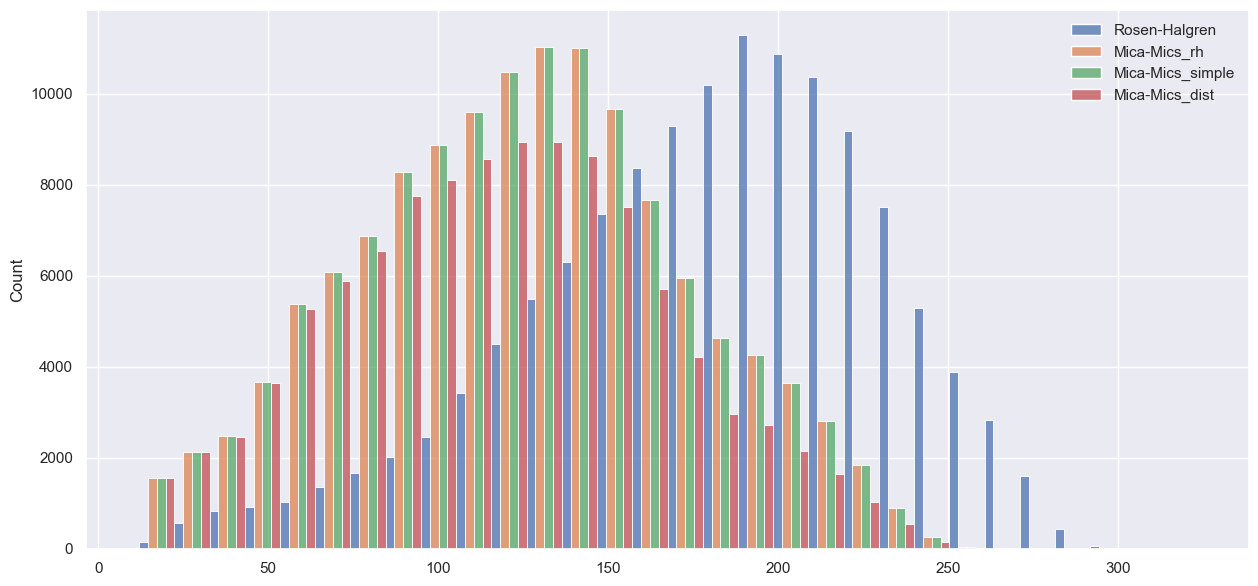

In [34]:
sns.histplot(df_lengths,bins=30,multiple="dodge", common_norm=False)